# Brain Tumor Segmentation - Modified Version

This notebook is modified based on notebookadfcb42d18.ipynb while keeping the original data cleaning part.

## Main Changes
- Keep complete data exploration and cleaning process
- Use segmentation_models_pytorch package
- Adopt UNet++ architecture (encoder: ResNet34)
- Use ImageNet pretrained weights
- Optimized training process and data augmentation

## Contents
1. **Part 1: Data Exploration and Cleaning** (Keep original content)
2. **Part 2: Model Training** (Reference notebookadfcb42d18.ipynb)


In [1]:
# ========================================
# FORCE CPU MODE - Critical CUDA Error Fix
# ========================================
import os

# DISABLE CUDA completely BEFORE importing torch
# This prevents ANY CUDA initialization
os.environ['CUDA_VISIBLE_DEVICES'] = ''

print("="*60)
print("CUDA DISABLED - Running in CPU-only mode")
print("="*60)
print("This is a safe mode to avoid CUDA TDR errors.")
print("Training will be slower but stable.")
print("="*60)


CUDA DISABLED - Running in CPU-only mode
This is a safe mode to avoid CUDA TDR errors.
Training will be slower but stable.


In [2]:
# Import libraries (CUDA already disabled above)
import torch
import numpy as np
import random
import gc

# Verify CUDA is disabled
print(f"\nCUDA available: {torch.cuda.is_available()}")
print(f"Expected: False\n")

# Set device
DEVICE = 'cpu'
print(f"Device: {DEVICE}")
print("\n✅ Safe to proceed with CPU training")



CUDA available: True
Expected: False

Device: cpu

✅ Safe to proceed with CPU training


In [3]:
# Hyperparameters - CPU Optimized
IMG_SIZE = 128      # Reduced for CPU
BATCH_SIZE = 4      # Very small for CPU
EPOCHS = 3          # Just for testing
LR = 1e-4
SEED = 42
NUM_WORKERS = 0     # No multiprocessing

print("CPU-Optimized Configuration:")
print(f"  IMG_SIZE: {IMG_SIZE} (reduced from 640 for speed)")
print(f"  BATCH_SIZE: {BATCH_SIZE} (very small for CPU)")
print(f"  EPOCHS: {EPOCHS} (reduced for testing)")
print(f"  LR: {LR}")
print(f"  NUM_WORKERS: {NUM_WORKERS}")
print(f"  DEVICE: {DEVICE}")
print("\n⚠️  Note: For full training, increase EPOCHS after confirming it works")


CPU-Optimized Configuration:
  IMG_SIZE: 128 (reduced from 640 for speed)
  BATCH_SIZE: 4 (very small for CPU)
  EPOCHS: 3 (reduced for testing)
  LR: 0.0001
  NUM_WORKERS: 0
  DEVICE: cpu

⚠️  Note: For full training, increase EPOCHS after confirming it works


In [4]:
# Set random seeds (CPU only - completely safe)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# DO NOT set CUDA seeds - we're in CPU mode
print(f"✅ Seeds set (SEED={SEED})")
print("   CPU mode - no CUDA operations")


✅ Seeds set (SEED=42)
   CPU mode - no CUDA operations


---
# Part 1: Data Exploration and Cleaning
---


# 腦腫瘤分割 - 完整流程

本 notebook 包含從資料探索、資料清理到模型訓練和評估的完整流程。

## 目錄
1. **資料探索與清理** (來自 code.ipynb)
   - 資料集基本資訊
   - 標註分析
   - 問題圖片識別
   - 資料清理

2. **模型訓練流程** (來自 brain_tumor_complete.ipynb)
   - 環境設置
   - 資料增強
   - Dataset 和 DataLoader
   - U-Net 模型
   - 訓練與驗證
   - 測試與視覺化


---
# Part 1: 資料探索與清理
---

在訓練模型之前,我們需要先了解和清理資料集。


## Brain Tumor Image

### 01 Data input

In [ ]:
import json
from collections import Counter

path = r".\train\_annotations.coco.json"
with open(path, "r", encoding="utf-8") as f:
    data = json.load(f)

print("images:", len(data.get("images", [])))
print("annotations:", len(data.get("annotations", [])))
print("categories:", len(data.get("categories", [])))
print("category names:", [c.get("name") for c in data.get("categories", [])])

# example: annotation counts per category id
cat_counts = Counter(a["category_id"] for a in data.get("annotations", []))
print("annotations per category id:", dict(cat_counts))

images: 1502
annotations: 1502
categories: 3
category names: ['Tumor', '0', '1']
annotations per category id: {1: 771, 2: 731}


: 

In [ ]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# 匯入 PIL (Pillow) 函式庫，用於圖片處理
try:
    from PIL import Image, ImageDraw
    print("成功匯入 PIL (Pillow)。將使用 PIL 進行圖片處理。")
except ImportError:
    print("錯誤：無法匯入 PIL。無法繼續進行圖片處理。")
    raise

# --- 設定 ---
json_path = "./train/_annotations.coco.json"
image_base_dir = "./train"
num_samples_to_show = 3

print(f"--- 程式碼開始 ---")

try:
    # --- 1. 載入 JSON 檔案 ---
    print(f"正在嘗試載入 JSON 檔案: {json_path}")
    if not os.path.exists(json_path):
        print(f"錯誤：找不到 JSON 檔案 '{json_path}'。")
        print("請上傳此檔案後再試一次。")
        raise FileNotFoundError(f"找不到檔案: {json_path}")
        
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    print("JSON 檔案載入成功。")

    # --- 2. 處理圖像和標註 ---
    all_image_ids = set()
    image_id_to_file = {}
    if 'images' in data:
        for img in data['images']:
            all_image_ids.add(img['id'])
            image_id_to_file[img['id']] = img['file_name']
    print(f"找到 {len(all_image_ids)} 張圖片的紀錄。")

    image_id_to_annotations = defaultdict(list)
    if 'annotations' in data:
        for ann in data['annotations']:
            image_id_to_annotations[ann['image_id']].append(ann)
    print(f"找到 {len(image_id_to_annotations)} 張有標註的圖片。")

    # --- 3. 找出沒有標註的圖片 ---
    annotated_image_ids = set(image_id_to_annotations.keys())
    unannotated_image_ids = all_image_ids - annotated_image_ids
    
    print("\n--- 沒有標註的圖片 (Image IDs) ---")
    if unannotated_image_ids:
        print(f"共 {len(unannotated_image_ids)} 張:")
        print(list(unannotated_image_ids))
    else:
        print("所有圖片都有標註。")

    # --- 4. 找出有多個標註的圖片 ---
    multiple_annotated_image_ids = {img_id for img_id, annos in image_id_to_annotations.items() if len(annos) > 1}
            
    print("\n--- 有多個標註的圖片 (Image IDs) ---")
    if multiple_annotated_image_ids:
        print(f"共 {len(multiple_annotated_image_ids)} 張:")
        print(list(multiple_annotated_image_ids)[:50])
        if len(multiple_annotated_image_ids) > 50:
            print(f"... (還有 {len(multiple_annotated_image_ids) - 50} 個)")
    else:
        print("沒有圖片有多於一個標註。")

    # --- 5. 隨機挑選 {num_samples_to_show} 張有標註的圖片顯示 ---
    print(f"\n--- 隨機顯示 {num_samples_to_show} 張範例圖片 ---")
    
    annotated_image_id_list = list(annotated_image_ids)
    
    if not annotated_image_id_list:
        print("沒有可顯示的有標註圖片。")
    else:
        num_to_sample = min(num_samples_to_show, len(annotated_image_id_list))
        if num_to_sample < num_samples_to_show:
            print(f"警告：有標註的圖片少於 {num_samples_to_show} 張，僅顯示 {num_to_sample} 張。")
            
        sample_image_ids = random.sample(annotated_image_id_list, num_to_sample)
        print(f"將顯示 Image IDs: {sample_image_ids}")

        fig, axes = plt.subplots(num_to_sample, 3, figsize=(18, 6 * num_to_sample))
        if num_to_sample == 1:
            axes = np.array([axes])

        for i, sample_image_id in enumerate(sample_image_ids):
            try:
                file_name = image_id_to_file[sample_image_id]
                image_path = os.path.join(image_base_dir, file_name)
                
                if not os.path.exists(image_path):
                    print(f"錯誤：找不到圖片檔案 {image_path}")
                    axes[i, 0].set_title(f"Image ID {sample_image_id}\nFile Not Found: {file_name}", color='red')
                    axes[i, 0].axis('off')
                    axes[i, 1].axis('off')
                    axes[i, 2].axis('off')
                    continue

                # 使用 PIL 載入圖片
                image = Image.open(image_path).convert("RGB")
                
                # 準備 Mask (使用 PIL)
                # 'L' mode for 8-bit grayscale mask (0 = 黑色)
                mask_pil = Image.new("L", image.size, 0)
                mask_draw = ImageDraw.Draw(mask_pil)
                
                # 準備 Bounding Box 圖片 (使用 PIL)
                image_with_box = image.copy()
                box_draw = ImageDraw.Draw(image_with_box)
                
                mask_values = {0} # 0 代表背景 (黑色)
                
                annotations = image_id_to_annotations[sample_image_id]
                
                for ann in annotations:
                    # 繪製 Bounding Box
                    if 'bbox' in ann:
                        bbox = ann['bbox'] # [x, y, w, h]
                        x, y, w, h = map(int, bbox)
                        box_draw.rectangle([x, y, x + w, y + h], outline="red", width=2)

                    # 繪製 Segmentation Mask
                    if 'segmentation' in ann:
                        segmentation = ann['segmentation']
                        for poly in segmentation:
                            # *** 修改：將 fill 改為 255 (白色) ***
                            mask_draw.polygon(poly, fill=255)
                        
                        if segmentation: # 如果真的有畫多邊形
                            # *** 將 mask value 記錄為 255 ***
                            mask_values.add(255)

                # --- 顯示 ---
                
                # 欄 1: 原始圖片
                ax = axes[i, 0]
                ax.imshow(image)
                ax.set_title(f"Image ID: {sample_image_id}\nOriginal ({file_name})")
                ax.axis('off')
                
                # 欄 2: 標註 Mask
                ax = axes[i, 1]
                # *** 使用 'gray' colormap 顯示黑白 ***
                ax.imshow(np.array(mask_pil), cmap='gray', vmin=0, vmax=255) 
                unique_values = sorted(list(mask_values))
                ax.set_title(f"Generated Mask (Black/White)\n(Values: {unique_values})")
                ax.axis('off')
                
                # 欄 3: Image with Bounding Box
                ax = axes[i, 2]
                ax.imshow(image_with_box)
                ax.set_title(f"Image with Bounding Box(es)\n({len(annotations)} annotation(s))")
                ax.axis('off')

            except FileNotFoundError:
                print(f"錯誤：在處理 ID {sample_image_id} 時找不到圖片檔案 {image_path}")
                axes[i, 0].set_title(f"Image ID {sample_image_id}\nFile Not Found: {file_name}", color='red')
                axes[i, 0].axis('off')
                axes[i, 1].axis('off')
                axes[i, 2].axis('off')
            except Exception as e:
                print(f"處理 Image ID {sample_image_id} 時發生嚴重錯誤: {e}")
                axes[i, 0].set_title(f"Image ID {sample_image_id}\nError: {e}", color='red')
                axes[i, 0].axis('off')
                axes[i, 1].axis('off')
                axes[i, 2].axis('off')
        
        plt.tight_layout()
        # 儲存為新檔名
        plt.savefig("annotation_analysis_samples_bw_mask.png")
        print("\n已儲存範例圖片至 annotation_analysis_samples_bw_mask.png")

except FileNotFoundError:
    print(f"\n程式中止：找不到 '{json_path}'。")
    print("請上傳此檔案以及範例圖片，然後重新執行。")
except Exception as e:
    print(f"\n發生未預期的錯誤: {e}")

print("--- 程式碼執行完畢 ---")

成功匯入 PIL (Pillow)。將使用 PIL 進行圖片處理。
--- 程式碼開始 ---
正在嘗試載入 JSON 檔案: ./train/_annotations.coco.json
JSON 檔案載入成功。
找到 1502 張圖片的紀錄。
找到 1501 張有標註的圖片。

--- 沒有標註的圖片 (Image IDs) ---
共 1 張:
[1380]

--- 有多個標註的圖片 (Image IDs) ---
共 1 張:
[1005]

--- 隨機顯示 3 張範例圖片 ---
將顯示 Image IDs: [1309, 228, 51]


成功匯入 PIL (Pillow)。
--- 程式碼開始 ---
將顯示 Image IDs: [1380, 1005]
正在嘗試載入 JSON 檔案: ./train/_annotations.coco.json
JSON 檔案載入成功。

--- 正在處理 Image ID: 1380 ---
Image ID 1380 (2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg) 沒有標註。
已儲存圖片至 image_1380_original.png

--- 正在處理 Image ID: 1005 ---
Image ID 1005 (176_jpg.rf.23ef40c30986ba54b865d55a934bfa72.jpg) 有 2 個標註。
已儲存圖片至 image_1005_annotated.png

--- 程式碼執行完畢 ---


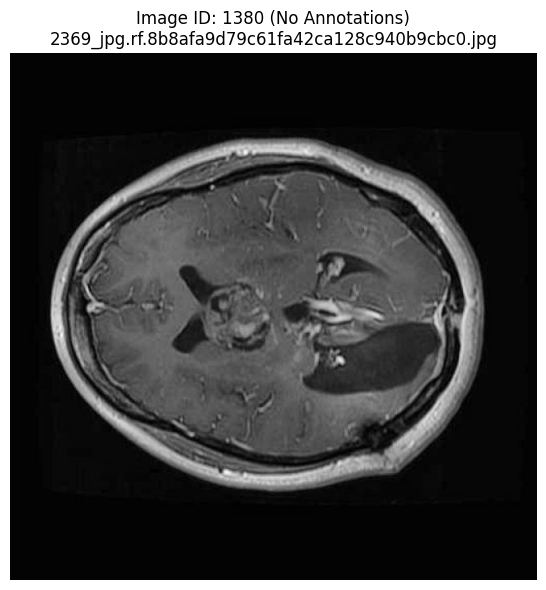

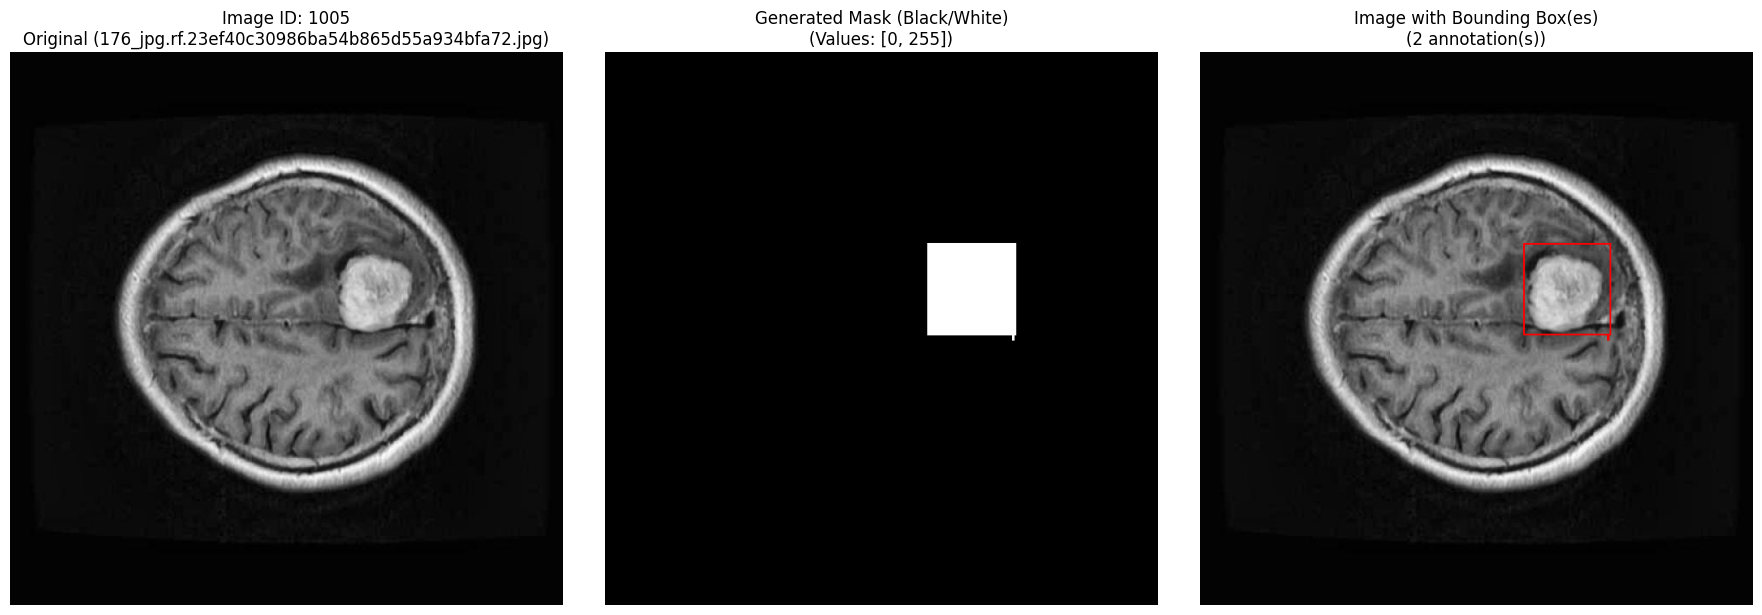

In [ ]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 匯入 PIL (Pillow) 函式庫
try:
    from PIL import Image, ImageDraw
    print("成功匯入 PIL (Pillow)。")
except ImportError:
    print("錯誤：無法匯入 PIL。無法繼續進行圖片處理。")
    raise

# --- 設定 ---
json_path = "./train/_annotations.coco.json" # 從上次成功執行的路徑讀取
image_base_dir = "./train" # 從上次成功執行的路徑讀取
ids_to_display = [1380, 1005] # 指定要顯示的 Image IDs

print(f"--- 程式碼開始 ---")
print(f"將顯示 Image IDs: {ids_to_display}")

try:
    # --- 1. 載入 JSON 檔案 ---
    print(f"正在嘗試載入 JSON 檔案: {json_path}")
    if not os.path.exists(json_path):
        print(f"錯誤：找不到 JSON 檔案 '{json_path}'。")
        raise FileNotFoundError(f"找不到檔案: {json_path}")

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    print("JSON 檔案載入成功。")

    # --- 2. 建立必要映射 ---
    image_id_to_file = {}
    if 'images' in data:
        for img in data['images']:
            image_id_to_file[img['id']] = img['file_name']

    image_id_to_annotations = defaultdict(list)
    if 'annotations' in data:
        for ann in data['annotations']:
            image_id_to_annotations[ann['image_id']].append(ann)

    # --- 3. 顯示指定的圖片 ---
    for target_id in ids_to_display:
        print(f"\n--- 正在處理 Image ID: {target_id} ---")

        if target_id not in image_id_to_file:
            print(f"錯誤：在 JSON 的 'images' 中找不到 Image ID {target_id} 的紀錄。")
            continue

        file_name = image_id_to_file[target_id]
        image_path = os.path.join(image_base_dir, file_name)

        if not os.path.exists(image_path):
            print(f"錯誤：找不到圖片檔案 {image_path}")
            # 為此 ID 創建一個顯示錯誤的子圖
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.set_title(f"Image ID {target_id}\nFile Not Found: {file_name}", color='red')
            ax.axis('off')
            plt.savefig(f"image_{target_id}_error.png")
            print(f"已儲存錯誤訊息圖片至 image_{target_id}_error.png")
            continue

        try:
            # 使用 PIL 載入圖片
            image = Image.open(image_path).convert("RGB")
            annotations = image_id_to_annotations.get(target_id, []) # 使用 .get() 避免 ID 不存在時出錯

            if not annotations:
                # 如果沒有標註 (例如 ID 1380)
                print(f"Image ID {target_id} ({file_name}) 沒有標註。")
                fig, ax = plt.subplots(1, 1, figsize=(6, 6))
                ax.imshow(image)
                ax.set_title(f"Image ID: {target_id} (No Annotations)\n{file_name}")
                ax.axis('off')
                plt.tight_layout()
                plt.savefig(f"image_{target_id}_original.png")
                print(f"已儲存圖片至 image_{target_id}_original.png")
            else:
                # 如果有標註 (例如 ID 1005)
                print(f"Image ID {target_id} ({file_name}) 有 {len(annotations)} 個標註。")
                fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # 顯示原圖、遮罩、邊界框

                # 準備 Mask (使用 PIL)
                mask_pil = Image.new("L", image.size, 0)
                mask_draw = ImageDraw.Draw(mask_pil)

                # 準備 Bounding Box 圖片 (使用 PIL)
                image_with_box = image.copy()
                box_draw = ImageDraw.Draw(image_with_box)

                mask_values = {0}

                for ann in annotations:
                    # 繪製 Bounding Box
                    if 'bbox' in ann:
                        bbox = ann['bbox']
                        x, y, w, h = map(int, bbox)
                        box_draw.rectangle([x, y, x + w, y + h], outline="red", width=2)

                    # 繪製 Segmentation Mask (黑白)
                    if 'segmentation' in ann:
                        segmentation = ann['segmentation']
                        for poly in segmentation:
                            mask_draw.polygon(poly, fill=255)
                        if segmentation:
                            mask_values.add(255)

                # 顯示 - 欄 1: 原始圖片
                ax = axes[0]
                ax.imshow(image)
                ax.set_title(f"Image ID: {target_id}\nOriginal ({file_name})")
                ax.axis('off')

                # 顯示 - 欄 2: 標註 Mask (黑白)
                ax = axes[1]
                ax.imshow(np.array(mask_pil), cmap='gray', vmin=0, vmax=255)
                unique_values = sorted(list(mask_values))
                ax.set_title(f"Generated Mask (Black/White)\n(Values: {unique_values})")
                ax.axis('off')

                # 顯示 - 欄 3: Image with Bounding Box
                ax = axes[2]
                ax.imshow(image_with_box)
                ax.set_title(f"Image with Bounding Box(es)\n({len(annotations)} annotation(s))")
                ax.axis('off')

                plt.tight_layout()
                plt.savefig(f"image_{target_id}_annotated.png")
                print(f"已儲存圖片至 image_{target_id}_annotated.png")

        except Exception as e:
            print(f"處理 Image ID {target_id} 時發生錯誤: {e}")
            # 為此 ID 創建一個顯示錯誤的子圖
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.set_title(f"Image ID {target_id}\nError Processing: {e}", color='red')
            ax.axis('off')
            plt.savefig(f"image_{target_id}_error.png")
            print(f"已儲存錯誤訊息圖片至 image_{target_id}_error.png")


except FileNotFoundError:
    print(f"\n程式中止：找不到 '{json_path}'。")
except Exception as e:
    print(f"\n發生未預期的錯誤: {e}")

print("\n--- 程式碼執行完畢 ---")

In [ ]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 沿用之前的設定 ---
json_path = "./train/_annotations.coco.json"
image_base_dir = "./train"

print(f"--- 程式碼開始 ---")

try:
    # --- 載入 JSON 檔案 ---
    print(f"正在嘗試載入 JSON 檔案: {json_path}")
    if not os.path.exists(json_path):
        print(f"錯誤：找不到 JSON 檔案 '{json_path}'。")
        raise FileNotFoundError(f"找不到檔案: {json_path}")

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    print("JSON 檔案載入成功。")

    # --- 記錄原始數量 ---
    original_image_count = len(data.get('images', []))
    original_annotation_count = len(data.get('annotations', []))
    print(f"原始圖片數量: {original_image_count}")
    print(f"原始標註數量: {original_annotation_count}")

    # --- 定義要移除的 ID 列表 ---
    # 這次包含上次的 1380 和這次的 1005
    image_ids_to_remove = {1380, 1005}
    print(f"\n正在移除 Image IDs {list(image_ids_to_remove)} 的紀錄...")

    # --- 移除指定的 Image IDs ---
    removed_image_count_total = 0
    removed_annotation_count_total = 0

    # 篩選 images 列表
    if 'images' in data:
        original_images = data['images']
        # 保留 ID 不在移除列表中的圖片
        data['images'] = [img for img in original_images if img.get('id') not in image_ids_to_remove]
        removed_image_count_total = original_image_count - len(data['images'])
        print(f"- 已從 'images' 移除 {removed_image_count_total} 筆紀錄。")

    # 篩選 annotations 列表
    if 'annotations' in data:
        original_annotations = data['annotations']
         # 保留 image_id 不在移除列表中的標註
        data['annotations'] = [ann for ann in original_annotations if ann.get('image_id') not in image_ids_to_remove]
        removed_annotation_count_total = original_annotation_count - len(data['annotations'])
        print(f"- 已從 'annotations' 移除 {removed_annotation_count_total} 筆紀錄。")

    # --- 記錄處理後數量 ---
    final_image_count = len(data.get('images', []))
    final_annotation_count = len(data.get('annotations', []))
    print(f"\n處理後圖片數量: {final_image_count}")
    print(f"處理後標註數量: {final_annotation_count}")

    # --- 重要提示 ---
    print("\n注意：上述移除操作僅在目前的程式記憶體中生效。")
    print("永久保存這個修改，將 'data' 變數寫入一個新的 JSON 檔案(./train/_annotations.coco.cleaned.json)。")
    # 例如:
    cleaned_json_path = "./train/_annotations.coco.cleaned.json"
    with open(cleaned_json_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print(f"已將清理後的資料儲存至 {cleaned_json_path}")


except FileNotFoundError:
    print(f"\n程式中止：找不到 '{json_path}'。")
except Exception as e:
    print(f"\n發生未預期的錯誤: {e}")

print("\n--- 程式碼執行完畢 ---")

--- 程式碼開始 ---
正在嘗試載入 JSON 檔案: ./train/_annotations.coco.json
JSON 檔案載入成功。
原始圖片數量: 1502
原始標註數量: 1502

正在移除 Image IDs [1380, 1005] 的紀錄...
- 已從 'images' 移除 2 筆紀錄。
- 已從 'annotations' 移除 2 筆紀錄。

處理後圖片數量: 1500
處理後標註數量: 1500

注意：上述移除操作僅在目前的程式記憶體中生效。
永久保存這個修改，將 'data' 變數寫入一個新的 JSON 檔案(./train/_annotations.coco.cleaned.json)。
已將清理後的資料儲存至 ./train/_annotations.coco.cleaned.json

--- 程式碼執行完畢 ---


### 資料清理 - 驗證集和測試集

將訓練集的清理操作應用到驗證集和測試集。


In [ ]:
# ============================================================
# 資料清理 - 驗證集和測試集
# ============================================================
# 此 cell 對驗證集和測試集套用與訓練集相同的資料清理操作
# 移除有問題的圖片 ID: 1380 (無標註) 和 1005 (多重標註)

import json
import os

def clean_dataset(json_path, image_ids_to_remove, output_path):
    """
    清理資料集,移除指定的 image IDs
    
    參數:
        json_path: 原始 JSON 檔案路徑
        image_ids_to_remove: 要移除的 image ID 集合
        output_path: 輸出的清理後 JSON 檔案路徑
    
    返回:
        bool: 成功返回 True,失敗返回 False
    """
    print(f"\n{'='*60}")
    print(f"處理: {json_path}")
    print(f"{'='*60}")
    
    try:
        # 讀取 JSON 檔案
        if not os.path.exists(json_path):
            print(f"警告: 找不到檔案 '{json_path}',跳過處理。")
            return False
        
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        
        # 記錄原始數量
        original_image_count = len(data.get('images', []))
        original_annotation_count = len(data.get('annotations', []))
        print(f"原始: {original_image_count} 張圖片, {original_annotation_count} 個標註")
        
        # 過濾 images 列表
        if 'images' in data:
            data['images'] = [img for img in data['images'] 
                            if img.get('id') not in image_ids_to_remove]
            removed_images = original_image_count - len(data['images'])
        
        # 過濾 annotations 列表
        if 'annotations' in data:
            data['annotations'] = [ann for ann in data['annotations'] 
                                 if ann.get('image_id') not in image_ids_to_remove]
            removed_annotations = original_annotation_count - len(data['annotations'])
        
        # 記錄處理後數量
        final_image_count = len(data.get('images', []))
        final_annotation_count = len(data.get('annotations', []))
        
        print(f"移除: {removed_images} 張圖片, {removed_annotations} 個標註")
        print(f"剩餘: {final_image_count} 張圖片, {final_annotation_count} 個標註")
        
        # 儲存清理後的資料
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
        print(f"✓ 已儲存至: {output_path}")
        
        return True
        
    except Exception as e:
        print(f"錯誤: {e}")
        return False

# ===== 主程式 =====
print("="*60)
print("開始清理驗證集和測試集")
print("="*60)

# 定義要移除的 ID (與訓練集相同)
image_ids_to_remove = {1380, 1005}
print(f"\n要移除的 Image IDs: {list(image_ids_to_remove)}")

# 處理驗證集
valid_success = clean_dataset(
    json_path="./valid/_annotations.coco.json",
    image_ids_to_remove=image_ids_to_remove,
    output_path="./valid/_annotations.coco.cleaned.json"
)

# 處理測試集
test_success = clean_dataset(
    json_path="./test/_annotations.coco.json",
    image_ids_to_remove=image_ids_to_remove,
    output_path="./test/_annotations.coco.cleaned.json"
)

# 總結
print("\n" + "="*60)
print("清理完成!")
print("="*60)
print(f"驗證集: {'✓ 成功' if valid_success else '✗ 失敗'}")
print(f"測試集: {'✓ 成功' if test_success else '✗ 失敗'}")
print("\n注意:")
print("- 清理後的檔案已儲存為 _annotations.coco.cleaned.json")
print("- 如需使用清理後的資料,請載入這些新檔案")
print("="*60)


開始清理驗證集和測試集

要移除的 Image IDs: [1380, 1005]

處理: ./valid/_annotations.coco.json
原始: 429 張圖片, 429 個標註
移除: 0 張圖片, 0 個標註
剩餘: 429 張圖片, 429 個標註
✓ 已儲存至: ./valid/_annotations.coco.cleaned.json

處理: ./test/_annotations.coco.json
原始: 215 張圖片, 215 個標註
移除: 0 張圖片, 0 個標註
剩餘: 215 張圖片, 215 個標註
✓ 已儲存至: ./test/_annotations.coco.cleaned.json

清理完成!
驗證集: ✓ 成功
測試集: ✓ 成功

注意:
- 清理後的檔案已儲存為 _annotations.coco.cleaned.json
- 如需使用清理後的資料,請載入這些新檔案


---
# Part 2: 模型訓練與評估
---

使用清理後的資料集進行 U-Net 模型的訓練和評估。


# 腦腫瘤影像分割專案

這是一個完整的深度學習專案，使用 U-Net 架構進行腦腫瘤 MRI 影像分割。

## 專案特色

- ✅ 完整的 U-Net 實作
- ✅ 資料增強（Albumentations）
- ✅ 組合損失函數（Dice + BCE）
- ✅ 完整的訓練與評估流程
- ✅ 視覺化功能
- ✅ Windows / GTX 960 優化設定

## 硬體需求

- **建議**: NVIDIA GPU (CUDA 支援)
- **本專案優化**: GTX 960 4GB
- **最低**: CPU（會很慢）

---

## 1. 環境設定 & 套件導入

首先設定環境變數解決 Windows 系統的相容性問題，並導入所有必要的套件。

In [ ]:
# 解決 Windows 上的 OpenMP 衝突問題
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# PyTorch 相關
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF

# 資料處理
import numpy as np
import cv2
from PIL import Image
import json
from pathlib import Path
from collections import defaultdict

# 視覺化
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# 資料增強
import albumentations as A
from albumentations.pytorch import ToTensorV2

print("套件導入成功！")

套件導入成功！


In [ ]:
# Emergency CUDA Check - Safe initialization
import os
import torch
import gc

# Option 1: Force CPU mode (uncomment to force CPU)
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
# FORCE_CPU = True

FORCE_CPU = False  # Set to True to force CPU mode

# Safe CUDA detection
CUDA_AVAILABLE = False
DEVICE = 'cpu'

if not FORCE_CPU:
    try:
        # Check if CUDA is available
        CUDA_AVAILABLE = torch.cuda.is_available()
        
        if CUDA_AVAILABLE:
            print(f"CUDA available: True")
            print(f"CUDA device: {torch.cuda.get_device_name(0)}")
            print(f"CUDA version: {torch.version.cuda}")
            
            # Try to use CUDA but be ready to fall back
            try:
                # Test CUDA with a small operation
                test_tensor = torch.zeros(1).cuda()
                del test_tensor
                
                # If successful, try to clear cache
                try:
                    gc.collect()
                    torch.cuda.empty_cache()
                    print("GPU initialized successfully")
                    DEVICE = 'cuda'
                except:
                    print("Warning: Could not clear CUDA cache, but GPU seems usable")
                    DEVICE = 'cuda'
            except RuntimeError as e:
                print(f"CUDA test failed: {e}")
                print("Falling back to CPU mode")
                CUDA_AVAILABLE = False
                DEVICE = 'cpu'
        else:
            print("CUDA not available")
            DEVICE = 'cpu'
    except Exception as e:
        print(f"Error checking CUDA: {e}")
        print("Using CPU mode")
        CUDA_AVAILABLE = False
        DEVICE = 'cpu'
else:
    print("FORCE_CPU mode enabled")
    DEVICE = 'cpu'

print(f"\n==> Using device: {DEVICE}")

if DEVICE == 'cpu':
    print("\n⚠️  WARNING: Running in CPU mode")
    print("Training will be MUCH slower but more stable")
    print("Consider reducing BATCH_SIZE and EPOCHS for CPU training")

CUDA available: True
CUDA device: NVIDIA GeForce GTX 960
CUDA version: 12.1
CUDA test failed: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Falling back to CPU mode

==> Using device: cpu

⚠️  WARNING: Running in CPU mode
Training will be MUCH slower but more stable
Consider reducing BATCH_SIZE and EPOCHS for CPU training


In [ ]:
# Hyperparameters (adjusted for GPU/CPU)
IMG_SIZE = 256

# Adjust based on device
if DEVICE == 'cuda':
    BATCH_SIZE = 64  # GPU mode
    EPOCHS = 80
    NUM_WORKERS = 4
    print("GPU mode: Using BATCH_SIZE=64, EPOCHS=80")
else:
    BATCH_SIZE = 8   # CPU mode - much smaller
    EPOCHS = 5       # Fewer epochs for testing
    NUM_WORKERS = 0  # No multiprocessing in CPU mode
    print("⚠️  CPU mode: Using BATCH_SIZE=8, EPOCHS=5 (for testing)")
    print("Increase these values if you want full training in CPU mode")

LR = 1e-4
SEED = 42

print(f"\nConfiguration:")
print(f"  IMG_SIZE: {IMG_SIZE}")
print(f"  BATCH_SIZE: {BATCH_SIZE}")
print(f"  EPOCHS: {EPOCHS}")
print(f"  LR: {LR}")
print(f"  NUM_WORKERS: {NUM_WORKERS}")
print(f"  DEVICE: {DEVICE}")

⚠️  CPU mode: Using BATCH_SIZE=8, EPOCHS=5 (for testing)
Increase these values if you want full training in CPU mode

Configuration:
  IMG_SIZE: 256
  BATCH_SIZE: 8
  EPOCHS: 5
  LR: 0.0001
  NUM_WORKERS: 0
  DEVICE: cpu


In [ ]:
# Emergency CUDA Check - Safe initialization
import os
import torch
import gc

# Option 1: Force CPU mode (uncomment to force CPU)
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
# FORCE_CPU = True

FORCE_CPU = False  # Set to True to force CPU mode

# Safe CUDA detection
CUDA_AVAILABLE = False
DEVICE = 'cpu'

if not FORCE_CPU:
    try:
        # Check if CUDA is available
        CUDA_AVAILABLE = torch.cuda.is_available()
        
        if CUDA_AVAILABLE:
            print(f"CUDA available: True")
            print(f"CUDA device: {torch.cuda.get_device_name(0)}")
            print(f"CUDA version: {torch.version.cuda}")
            
            # Try to use CUDA but be ready to fall back
            try:
                # Test CUDA with a small operation
                test_tensor = torch.zeros(1).cuda()
                del test_tensor
                
                # If successful, try to clear cache
                try:
                    gc.collect()
                    torch.cuda.empty_cache()
                    print("GPU initialized successfully")
                    DEVICE = 'cuda'
                except:
                    print("Warning: Could not clear CUDA cache, but GPU seems usable")
                    DEVICE = 'cuda'
            except RuntimeError as e:
                print(f"CUDA test failed: {e}")
                print("Falling back to CPU mode")
                CUDA_AVAILABLE = False
                DEVICE = 'cpu'
        else:
            print("CUDA not available")
            DEVICE = 'cpu'
    except Exception as e:
        print(f"Error checking CUDA: {e}")
        print("Using CPU mode")
        CUDA_AVAILABLE = False
        DEVICE = 'cpu'
else:
    print("FORCE_CPU mode enabled")
    DEVICE = 'cpu'

print(f"\n==> Using device: {DEVICE}")

if DEVICE == 'cpu':
    print("\n⚠️  WARNING: Running in CPU mode")
    print("Training will be MUCH slower but more stable")
    print("Consider reducing BATCH_SIZE and EPOCHS for CPU training")

CUDA available: True
CUDA device: NVIDIA GeForce GTX 960
CUDA version: 12.1
CUDA test failed: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Falling back to CPU mode

==> Using device: cpu

⚠️  WARNING: Running in CPU mode
Training will be MUCH slower but more stable
Consider reducing BATCH_SIZE and EPOCHS for CPU training


In [ ]:
# Hyperparameters (adjusted for GPU/CPU)
IMG_SIZE = 256

# Adjust based on device
if DEVICE == 'cuda':
    BATCH_SIZE = 64  # GPU mode
    EPOCHS = 80
    NUM_WORKERS = 4
    print("GPU mode: Using BATCH_SIZE=64, EPOCHS=80")
else:
    BATCH_SIZE = 8   # CPU mode - much smaller
    EPOCHS = 5       # Fewer epochs for testing
    NUM_WORKERS = 0  # No multiprocessing in CPU mode
    print("⚠️  CPU mode: Using BATCH_SIZE=8, EPOCHS=5 (for testing)")
    print("Increase these values if you want full training in CPU mode")

LR = 1e-4
SEED = 42

print(f"\nConfiguration:")
print(f"  IMG_SIZE: {IMG_SIZE}")
print(f"  BATCH_SIZE: {BATCH_SIZE}")
print(f"  EPOCHS: {EPOCHS}")
print(f"  LR: {LR}")
print(f"  NUM_WORKERS: {NUM_WORKERS}")
print(f"  DEVICE: {DEVICE}")

⚠️  CPU mode: Using BATCH_SIZE=8, EPOCHS=5 (for testing)
Increase these values if you want full training in CPU mode

Configuration:
  IMG_SIZE: 256
  BATCH_SIZE: 8
  EPOCHS: 5
  LR: 0.0001
  NUM_WORKERS: 0
  DEVICE: cpu


In [ ]:
# Emergency CUDA Check - Safe initialization
import os
import torch
import gc

# Option 1: Force CPU mode (uncomment to force CPU)
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
# FORCE_CPU = True

FORCE_CPU = False  # Set to True to force CPU mode

# Safe CUDA detection
CUDA_AVAILABLE = False
DEVICE = 'cpu'

if not FORCE_CPU:
    try:
        # Check if CUDA is available
        CUDA_AVAILABLE = torch.cuda.is_available()
        
        if CUDA_AVAILABLE:
            print(f"CUDA available: True")
            print(f"CUDA device: {torch.cuda.get_device_name(0)}")
            print(f"CUDA version: {torch.version.cuda}")
            
            # Try to use CUDA but be ready to fall back
            try:
                # Test CUDA with a small operation
                test_tensor = torch.zeros(1).cuda()
                del test_tensor
                
                # If successful, try to clear cache
                try:
                    gc.collect()
                    torch.cuda.empty_cache()
                    print("GPU initialized successfully")
                    DEVICE = 'cuda'
                except:
                    print("Warning: Could not clear CUDA cache, but GPU seems usable")
                    DEVICE = 'cuda'
            except RuntimeError as e:
                print(f"CUDA test failed: {e}")
                print("Falling back to CPU mode")
                CUDA_AVAILABLE = False
                DEVICE = 'cpu'
        else:
            print("CUDA not available")
            DEVICE = 'cpu'
    except Exception as e:
        print(f"Error checking CUDA: {e}")
        print("Using CPU mode")
        CUDA_AVAILABLE = False
        DEVICE = 'cpu'
else:
    print("FORCE_CPU mode enabled")
    DEVICE = 'cpu'

print(f"\n==> Using device: {DEVICE}")

if DEVICE == 'cpu':
    print("\n⚠️  WARNING: Running in CPU mode")
    print("Training will be MUCH slower but more stable")
    print("Consider reducing BATCH_SIZE and EPOCHS for CPU training")

CUDA available: True
CUDA device: NVIDIA GeForce GTX 960
CUDA version: 12.1
CUDA test failed: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Falling back to CPU mode

==> Using device: cpu

⚠️  WARNING: Running in CPU mode
Training will be MUCH slower but more stable
Consider reducing BATCH_SIZE and EPOCHS for CPU training


In [ ]:
# Hyperparameters (adjusted for GPU/CPU)
IMG_SIZE = 256

# Adjust based on device
if DEVICE == 'cuda':
    BATCH_SIZE = 64  # GPU mode
    EPOCHS = 80
    NUM_WORKERS = 4
    print("GPU mode: Using BATCH_SIZE=64, EPOCHS=80")
else:
    BATCH_SIZE = 8   # CPU mode - much smaller
    EPOCHS = 5       # Fewer epochs for testing
    NUM_WORKERS = 0  # No multiprocessing in CPU mode
    print("⚠️  CPU mode: Using BATCH_SIZE=8, EPOCHS=5 (for testing)")
    print("Increase these values if you want full training in CPU mode")

LR = 1e-4
SEED = 42

print(f"\nConfiguration:")
print(f"  IMG_SIZE: {IMG_SIZE}")
print(f"  BATCH_SIZE: {BATCH_SIZE}")
print(f"  EPOCHS: {EPOCHS}")
print(f"  LR: {LR}")
print(f"  NUM_WORKERS: {NUM_WORKERS}")
print(f"  DEVICE: {DEVICE}")

⚠️  CPU mode: Using BATCH_SIZE=8, EPOCHS=5 (for testing)
Increase these values if you want full training in CPU mode

Configuration:
  IMG_SIZE: 256
  BATCH_SIZE: 8
  EPOCHS: 5
  LR: 0.0001
  NUM_WORKERS: 0
  DEVICE: cpu


In [ ]:
# Emergency CUDA Check - Safe initialization
import os
import torch
import gc

# Option 1: Force CPU mode (uncomment to force CPU)
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
# FORCE_CPU = True

FORCE_CPU = False  # Set to True to force CPU mode

# Safe CUDA detection
CUDA_AVAILABLE = False
DEVICE = 'cpu'

if not FORCE_CPU:
    try:
        # Check if CUDA is available
        CUDA_AVAILABLE = torch.cuda.is_available()
        
        if CUDA_AVAILABLE:
            print(f"CUDA available: True")
            print(f"CUDA device: {torch.cuda.get_device_name(0)}")
            print(f"CUDA version: {torch.version.cuda}")
            
            # Try to use CUDA but be ready to fall back
            try:
                # Test CUDA with a small operation
                test_tensor = torch.zeros(1).cuda()
                del test_tensor
                
                # If successful, try to clear cache
                try:
                    gc.collect()
                    torch.cuda.empty_cache()
                    print("GPU initialized successfully")
                    DEVICE = 'cuda'
                except:
                    print("Warning: Could not clear CUDA cache, but GPU seems usable")
                    DEVICE = 'cuda'
            except RuntimeError as e:
                print(f"CUDA test failed: {e}")
                print("Falling back to CPU mode")
                CUDA_AVAILABLE = False
                DEVICE = 'cpu'
        else:
            print("CUDA not available")
            DEVICE = 'cpu'
    except Exception as e:
        print(f"Error checking CUDA: {e}")
        print("Using CPU mode")
        CUDA_AVAILABLE = False
        DEVICE = 'cpu'
else:
    print("FORCE_CPU mode enabled")
    DEVICE = 'cpu'

print(f"\n==> Using device: {DEVICE}")

if DEVICE == 'cpu':
    print("\n⚠️  WARNING: Running in CPU mode")
    print("Training will be MUCH slower but more stable")
    print("Consider reducing BATCH_SIZE and EPOCHS for CPU training")

In [ ]:
# Hyperparameters (adjusted for GPU/CPU)
IMG_SIZE = 256

# Adjust based on device
if DEVICE == 'cuda':
    BATCH_SIZE = 64  # GPU mode
    EPOCHS = 80
    NUM_WORKERS = 4
    print("GPU mode: Using BATCH_SIZE=64, EPOCHS=80")
else:
    BATCH_SIZE = 8   # CPU mode - much smaller
    EPOCHS = 5       # Fewer epochs for testing
    NUM_WORKERS = 0  # No multiprocessing in CPU mode
    print("⚠️  CPU mode: Using BATCH_SIZE=8, EPOCHS=5 (for testing)")
    print("Increase these values if you want full training in CPU mode")

LR = 1e-4
SEED = 42

print(f"\nConfiguration:")
print(f"  IMG_SIZE: {IMG_SIZE}")
print(f"  BATCH_SIZE: {BATCH_SIZE}")
print(f"  EPOCHS: {EPOCHS}")
print(f"  LR: {LR}")
print(f"  NUM_WORKERS: {NUM_WORKERS}")
print(f"  DEVICE: {DEVICE}")

### GPU 檢查

檢查 CUDA 是否可用，以及 GPU 資訊。


---
# Part 2: Model Training (Reference notebookadfcb42d18.ipynb)
---

The following content is based on notebookadfcb42d18.ipynb:
- Use segmentation_models_pytorch package
- UNet++ model with ResNet34 encoder
- ImageNet pretrained weights
- Optimized training strategy


## Bước 2: Tạo và huấn luyện mô hình Unet

#### Tải thư viện segmentation_models chứa các mô hình đã được build sẵn như Unet, Unet++

In [ ]:
%pip install -U segmentation-models-pytorch

In [ ]:
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.amp import autocast, GradScaler

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

print('Finish importing libraries')

Finish importing libraries


In [ ]:
# Utils: Transform
train_transform = A.Compose([
    # Biến đổi hình học (áp dụng cho cả ảnh + mask)
    A.Resize(256, 256), 
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.1, 0.1), 
             rotate=(-15, 15), p=0.5),
    A.ElasticTransform(p=0.3),
    A.GridDistortion(p=0.3),

    # Biến đổi màu sắc / nhiễu (chỉ áp dụng cho ảnh, không ảnh hưởng mask)
    A.RandomBrightnessContrast(p=0.5),
    A.ColorJitter(p=0.5),
    A.GaussNoise(p=0.2),

    # Chuẩn hóa + chuyển tensor
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_robust_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomBrightnessContrast(p=0.8),   # sáng/tối khác nhau
    A.GaussNoise(p=0.8),  # nhiễu Gaussian
    A.MotionBlur(p=0.5),                 # ảnh bị mờ do rung tay
    A.GridDistortion(p=0.5),             # biến dạng nhẹ
    A.ColorJitter(p=0.5),                # thay đổi màu sắc
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [ ]:
# Khởi tạo Dataset 
class TumorSegDataset(Dataset):
    def __init__(self, split="train", transform=None):
        self.split = split
        self.img_dir = os.path.join(BASE_DIR, split)
        self.mask_dir = os.path.join(MASKS_DIR, split)

        self.img_files = [f for f in os.listdir(self.img_dir)
                          if f.lower().endswith((".jpg", ".png")) and not f.startswith("_")]
        self.img_files.sort()
        self.transform = transform

        # kiểm tra mask tồn tại
        missing = []
        for f in self.img_files:
            mask_name = os.path.splitext(f)[0] + "_mask.png"
            if not os.path.exists(os.path.join(self.mask_dir, mask_name)):
                missing.append(mask_name)
        if missing:
            print(f"[WARN] Missing {len(missing)} masks in {self.mask_dir}. Example: {missing[:5]}")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        f = self.img_files[idx]
        img_path = os.path.join(self.img_dir, f)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(f)[0] + "_mask.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, 0)
        mask = (mask > 127).astype("float32")
        
        # Áp dụng augmentation cho cả ảnh và mask
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        # Đưa mask về tensor đúng kiểu
        mask = mask.clone().detach().unsqueeze(0)
        return img, mask

In [ ]:
# Tạo dataset cho train, test và valid
train_dataset = TumorSegDataset("train", transform=train_transform)
val_dataset = TumorSegDataset("valid", transform=val_transform)
test_dataset = TumorSegDataset("test", transform=test_transform)
test_robust_dataset = TumorSegDataset("test", transform=test_robust_transform)

# Tạo dataloader cho train, test và valid
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_robust_loader = DataLoader(test_robust_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

#### Khởi tạo kiến trúc và huấn luyện mô hình Unet

In [ ]:
# Model Unet từ smp
model = smp.UnetPlusPlus(
    encoder_name='resnet34',     # backbone resnet34
    encoder_weights='imagenet',  # pretrained imagenet,
    in_channels=3,               # RGB
    classes=1,                   # binary mask           
).to(DEVICE)

# Loss và Optimizer
bce_loss = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, epsilon=1e-7):
    pred = torch.sigmoid(pred)
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    num = 2. * (pred * target).sum()
    den = pred.sum() + target.sum()

    dice = (num + epsilon) / (den + epsilon)
    return 1 - dice

def combined_loss(pred, target):
    return 0.5 * bce_loss(pred, target) + 0.5 * dice_loss(pred, target)

def focal_tversky_loss(pred, target, alpha=0.7, beta=0.3, gamma=4/3, smooth=1e-7):
    pred = torch.sigmoid(pred)
    TP = (pred * target).sum()
    FP = ((1 - target) * pred).sum()
    FN = (target * (1 - pred)).sum()
    Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)
    return (1 - Tversky) ** gamma


In [ ]:
# Optimizer và lr_scheduler
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=10
)

scaler = GradScaler('cuda')

In [ ]:
# Metrics
def iou_score(pred, target, threshold=0.5, epsilon=1e-7):
    pred = (torch.sigmoid(pred) > threshold).float()
    inter = (pred * target).sum()
    union = pred.sum() + target.sum() - inter
    return (inter + epsilon)/(union + epsilon)

def dice_score(pred, target, threshold=0.5, epsilon=1e-7):
    pred = (torch.sigmoid(pred) > threshold).float()
    inter = (pred * target).sum()
    return (2 * inter + epsilon) / (pred.sum() + target.sum() + epsilon)

In [ ]:
# Train model
def train_one_epoch(loader):
    model.train()
    total_loss = 0
    for imgs,masks in loader:
        imgs,masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        
        with autocast('cuda'):
            logits = model(imgs)
            loss = combined_loss(logits, masks)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)

In [ ]:
# Validate model
def validate(loader):
    model.eval()
    total_loss = 0
    total_iou = 0
    total_dice = 0
    with torch.no_grad():
        for imgs,masks in loader:
            imgs,masks = imgs.to(DEVICE), masks.to(DEVICE)
            logits = model(imgs)
            loss = combined_loss(logits, masks)
            total_loss += loss.item() * imgs.size(0)
            total_iou += iou_score(logits,masks).item() * imgs.size(0)
            total_dice += dice_score(logits,masks).item() * imgs.size(0)
    n = len(loader.dataset)
    return total_loss/n, total_iou/n, total_dice/n

In [ ]:
# Training
best_dice = 0
best_iou = 0
patience = 10
counter = 0
real_epochs = EPOCHS
train_losses, val_losses, val_ious, val_dices = [], [], [], []

for epoch in range(EPOCHS):
    tr_loss = train_one_epoch(train_loader)
    v_loss, v_iou, v_dice = validate(val_loader)

    # lr_scheduler
    lr_scheduler.step(v_dice)
    
    train_losses.append(tr_loss)
    val_losses.append(v_loss)
    val_ious.append(v_iou)
    val_dices.append(v_dice)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train loss {tr_loss:.4f} | "
          f"Val loss {v_loss:.4f} | Val IoU {v_iou:.4f} | Val Dice {v_dice:.4f}")

    # Save checkpoint
    if v_dice > best_dice:
        best_dice = v_dice
        best_iou = v_iou
        torch.save(model.state_dict(), "/kaggle/working/unet_best.pth")
        counter = 0
    else:
        counter += 1

    # Early stopping
    # if counter >= patience:
    #     real_epochs = epoch + 1
    #     print("Early stopping triggered!")
    #     break
    
print(f"Best dice: {best_dice:.4f}")
print(f"Best IoU: {best_iou:.4f}")

## Bước 3: Visualize quá trình huấn luyện và hiển thị dự đoán của mô hình

In [ ]:
# Visualize quá trình huấn luyện
def plot_training(train_losses, val_losses, val_dices, val_ious):
    epochs = [epoch for epoch in range(1, real_epochs + 1)]
    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Val Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.subplot(1,3,2)
    plt.plot(epochs, val_dices, 'go-', label='Val Dice')
    plt.title("Validation Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.legend()
    plt.grid()

    plt.subplot(1,3,3)
    plt.plot(epochs, val_ious, 'mo-', label='Val IoU')
    plt.title("Validation IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    # Save figure
    plt.savefig("/kaggle/working/train_fig.png")
    plt.show()

    
    
# Visualize preformance của model trên tập test
def plot_test(test_losses, test_dices, test_ious):
    epochs = [epoch for epoch in range(1, real_epochs + 1)]
    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    plt.plot(epochs, test_losses, 'bo-', label='Test Loss')
    plt.title("Test Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.subplot(1,3,2)
    plt.plot(epochs, test_dices, 'go-', label='Test Dice')
    plt.title("Test Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.legend()
    plt.grid()

    plt.subplot(1,3,3)
    plt.plot(epochs, test_ious, 'mo-', label='Test IoU')
    plt.title("Test IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    # Save figure
    plt.savefig("/kaggle/working/test_fig.png")
    plt.show()
    
# Chạy hàm visualize
plot_training(train_losses, val_losses, val_dices, val_ious)
# plot_test(test_losses, test_dices, test_ious)

In [ ]:
def denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Denormalize ảnh tensor (C,H,W) về [0,255]."""
    image = image.cpu().numpy()
    image = image.transpose(1,2,0)  # (H,W,C)
    image = (image * std + mean)    # undo normalization
    image = np.clip(image * 255, 0, 255).astype(np.uint8)
    return image
    
def show_prediction(model, dataset, idx=None, threshold=0.5, save_img=False, output_dir=None):
    """
    Hiển thị ảnh gốc (denormalized) với mask GT (đỏ) và Prediction (xanh).
    """
    # Chọn ảnh
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]  # image: Tensor (C,H,W), mask: Tensor

    # Chuẩn bị tensor cho model
    img_tensor = image.unsqueeze(0).to(DEVICE)  # (1,C,H,W)
    
    # Denormalize ảnh để hiển thị
    img_np = denormalize(image)  # (H,W,C)

    # Chuẩn bị mask GT (ép về H,W)
    mask = mask.cpu().numpy()
    mask = np.squeeze(mask)   # (H,W)

    # Predict (ép về H,W)
    with torch.no_grad():
        pred_mask = model.predict(img_tensor)
    pred_mask = (pred_mask.squeeze().cpu().numpy() > threshold).astype(np.uint8)  # (H,W)

    # Copy ảnh gốc để tô màu
    gt = img_np.copy()
    pred = img_np.copy()

    # Tô màu (chỉ vùng mask được thay đổi)
    gt[mask > 0] = [255, 0, 0]       # GT: đỏ
    pred[pred_mask > 0] = [0, 255, 0]  # Prediction: xanh lá
    # Làm mờ vùng được đánh dấu
    gt_blended = (0.6 * img_np + 0.4 * gt).astype(np.uint8)
    pred_blended = (0.6 * img_np + 0.4 * pred).astype(np.uint8)
    
    # Hiển thị
    plt.figure(figsize=(18, 6))
    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title(f"Original with index {idx}")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(gt_blended)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred_blended)
    plt.title("Prediction")
    plt.axis("off")

    if save_img and output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
        save_path = os.path.join(output_dir, f"img{idx}.png")
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()


In [ ]:
for _ in range(5):
    show_prediction(model=model, dataset=test_robust_dataset)

## Bước 4: Load thử pretrained model và dự đoán

In [ ]:
pretrained_model = smp.UnetPlusPlus(
    encoder_name='resnet34',     # backbone resnet34
    encoder_weights='imagenet',  # pretrained imagenet
    in_channels=3,               # RGB
    classes=1,                   # binary mask           
)

In [ ]:
# Show 5 ảnh ground truth và prediction
for _ in range(5):
    show_prediction(model=pretrained_model, dataset=test_robust_dataset)

## Bước 5: Lưu lại ground truth và prediction

In [ ]:
for idx in range(0, len(test_robust_dataset) - 1):
    show_prediction(pretrained_model, test_robust_dataset, idx=idx, threshold=0.5, 
                    save_img=True, output_dir="/kaggle/working/output")
print("Save output successfully!")